In [1]:
import pandas as pd
import numpy as np
import matplotlib
import dask.dataframe as dd
import folium
import datetime
import time

matplotlib.use('nbagg')

import matplotlib.pylab as plt
import seaborn as sns #Plots
from matplotlib import rcParams #Size of plots  
import gpxpy.geo #Get the haversine distance
from sklearn.cluster import MiniBatchKMeans, KMeans #Clustering
import math
import pickle
import os

mingw_path = 'C:\\Users\\Bhargav\\AppData\\Local\\Programs\\msys64\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
month = pd.read_csv('C:\\Users\\Bhargav\\Desktop\\TaxiDemandPrediction\\tripdata.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [5]:
import os
month = pd.read_csv('C:\\Users\\Bhargav\\Desktop\\TaxiDemandPrediction\\tripdata.csv')
os.environ["PATH"] += os.pathsep + "C:\\Users\\Bhargav\\AppData\\Roaming\\Python\\Python310\\site-packages\\graphviz"

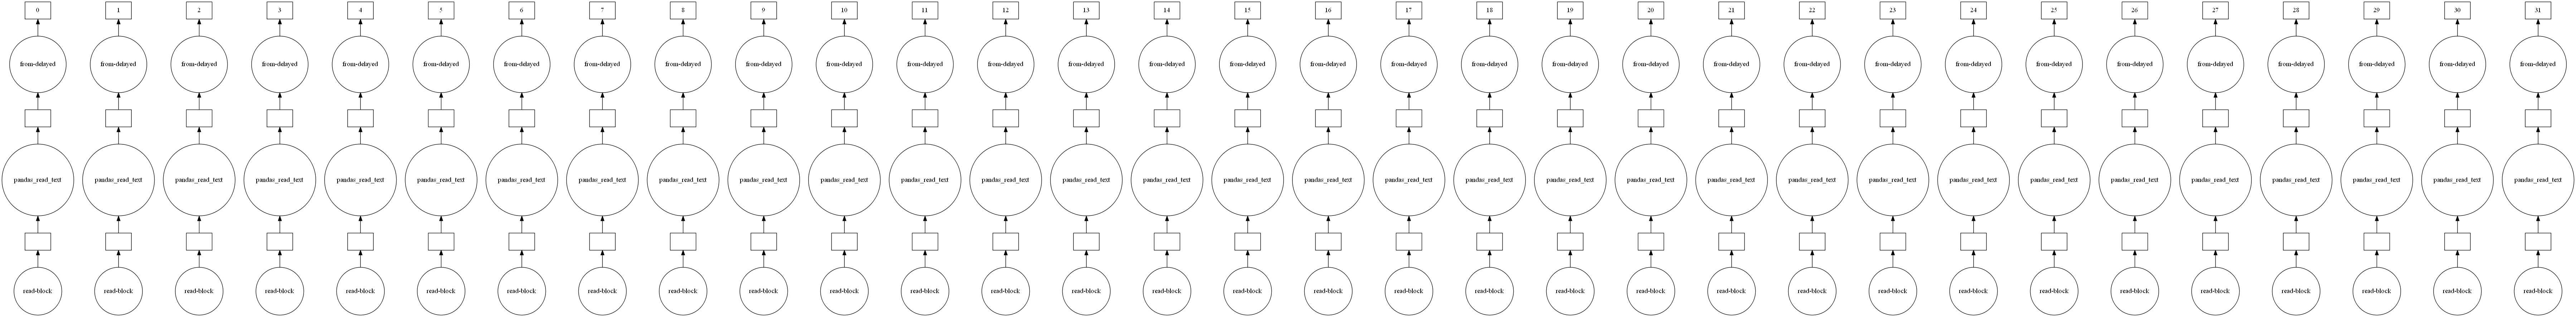

In [ ]:
month.visualize()

In [26]:
import os
os.environ["PATH"] += os.pathsep + "C:\\Users\\Bhargav\\AppData\\Roaming\\Python\\Python310\\site-packages\\graphviz"

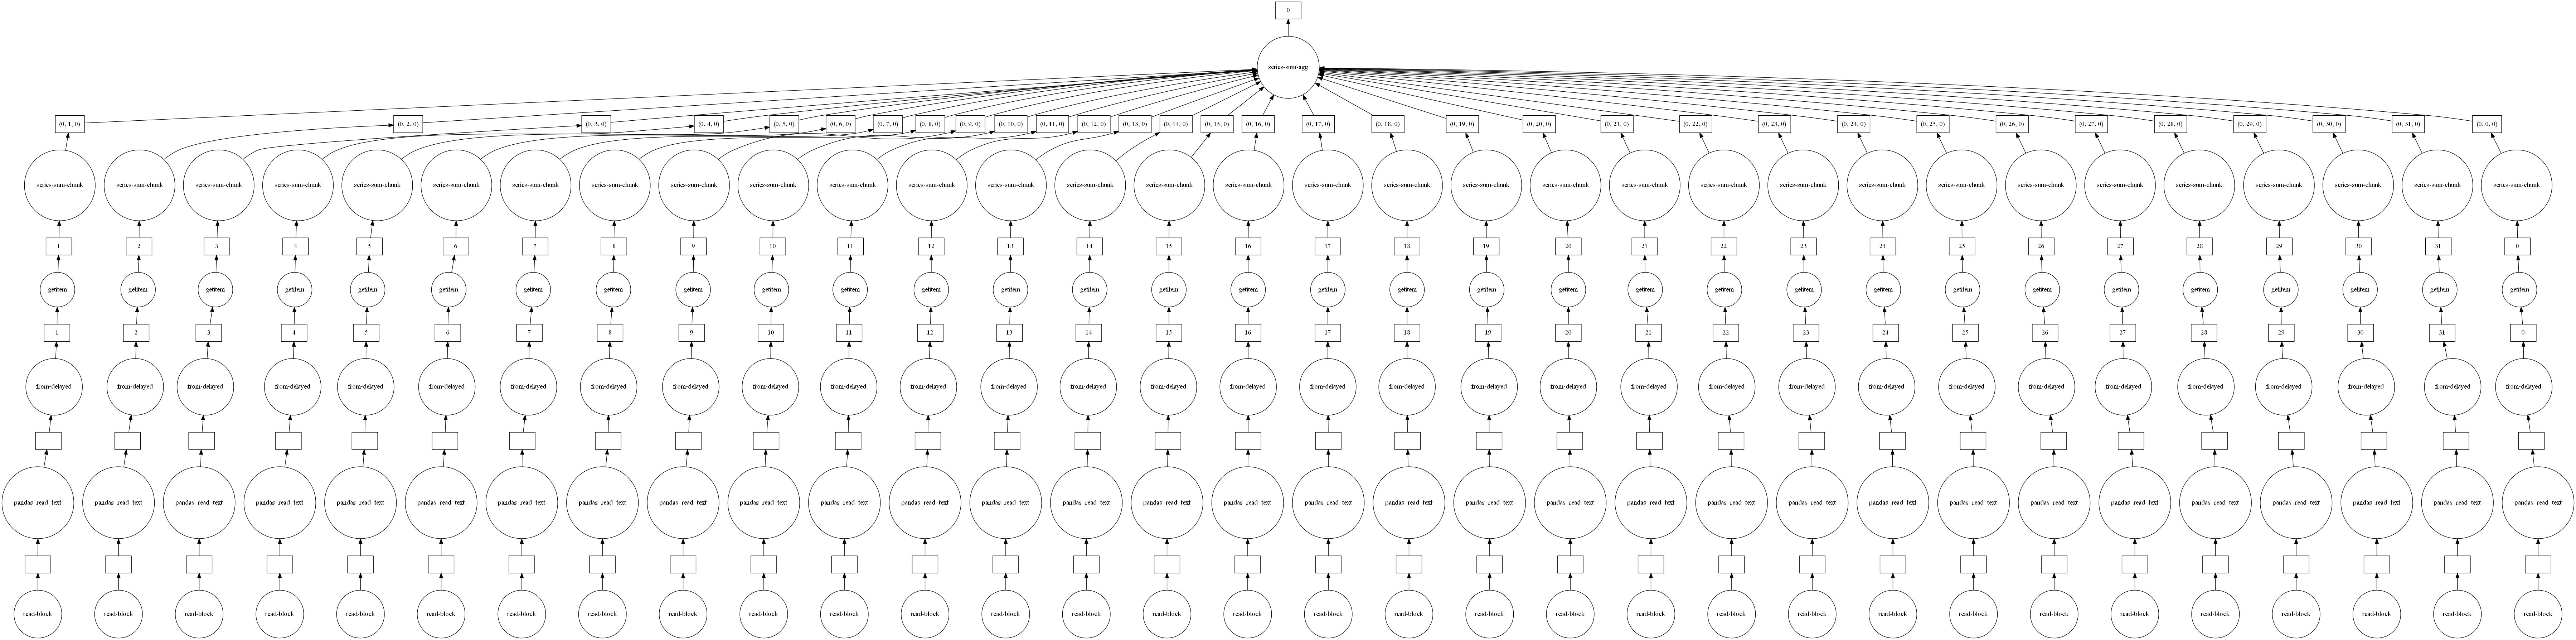

In [ ]:
month.fare_amount.sum().visualize()

## Data Cleaning

In this section, we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error.


In [6]:
#
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


### 1. Pickup Latitude and Pickup Longitude


New York is bounded by the location cordinates (40.58, -74.15) & (40.92, -73.70)
Hence, any cordinates not within these cordinates are not considered.


In [7]:
#
# plotting pickup cordinates which are outside the bounding box of New York 
# collect all the points outside the bounding box of NYC to outlier locations

outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.58)| \
                   (month.pickup_longitude >= -73.70) | (month.pickup_latitude >= 40.92))]

# creating a map with the a base location
map_osm = folium.Map(location = [40.73, -73.99], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map
sample_locations = outlier_locations.head(10000)
for i, j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'], j['pickup_longitude']))).add_to(map_osm)
map_osm

### 2. Dropoff Latitude & Dropoff Longitude


In [30]:
#
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.58)| \
                   (month.dropoff_longitude >= -73.70) | (month.dropoff_latitude >= 40.92))]

map_osm = folium.Map(location = [40.73, -73.99], tiles='Stamen Toner')

sample_locations = outlier_locations.head(10000)
for i, j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'], j['dropoff_longitude']))).add_to(map_osm)
map_osm

<b>Observation:-</b> The observations here are similar to those obtained while analysing pickup latitude and longitude.


### 3. Trip Durations


In [ ]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(month)

In [ ]:
print(frame_with_durations.head())

   passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  
0  1.421329e+09   5.285319  
1  1.420902e+09   9.983193  
2  1.420902e+09  10.746269  
3  1.420902e+09  16.071429  
4  1.420902e+

<IPython.core.display.Javascript object>


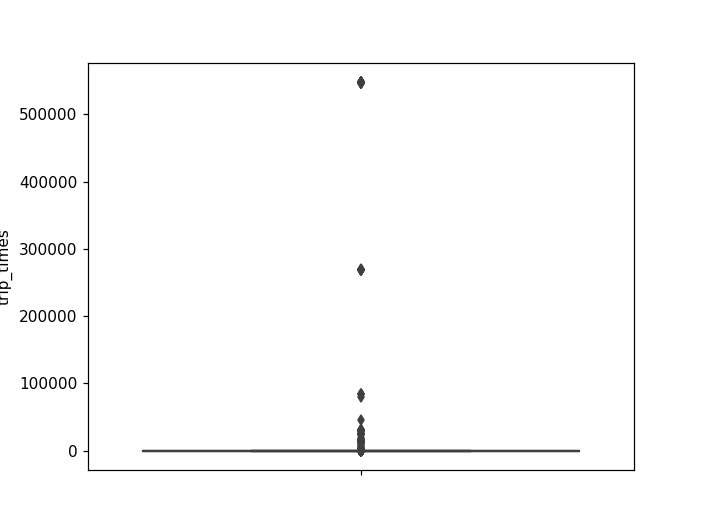

In [ ]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data = frame_with_durations)
plt.show()

In [ ]:
# calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis = None)
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ", var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.6333333333


In [ ]:
#looking further from the 99th percecntile
for i in range(90, 100):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis = None)
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ", var[-1])

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is  548555.6333333333


In [ ]:
# removing data based on our analysis
frame_with_durations_modified = frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)] #max travel is 12 hrs = 720 mins

<IPython.core.display.Javascript object>


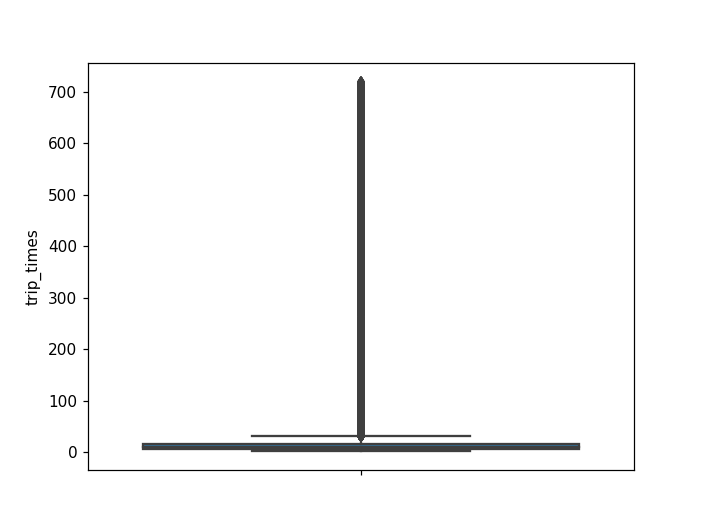

In [ ]:
# box-plot after removal of outliers
sns.boxplot(y = "trip_times", data = frame_with_durations_modified)
plt.show()

<IPython.core.display.Javascript object>


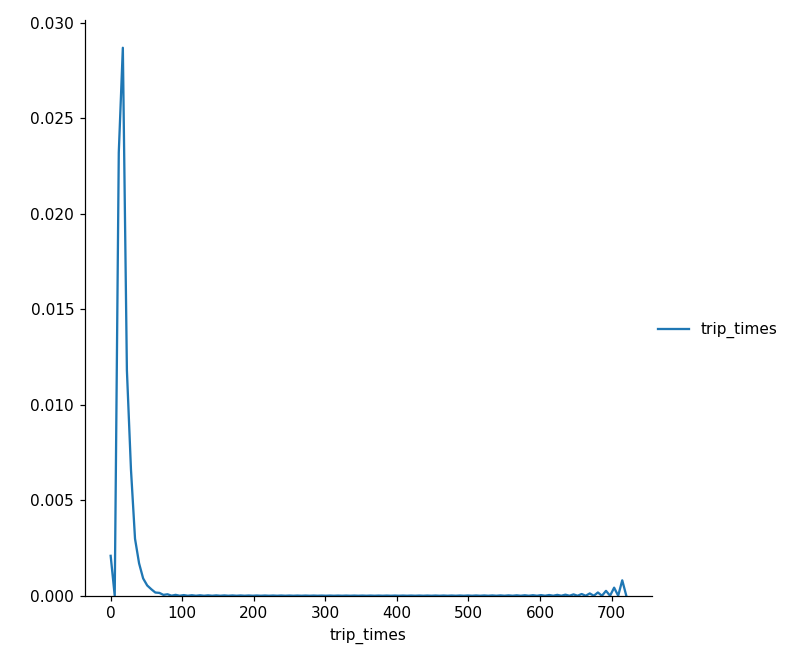

In [ ]:
# pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend()
plt.show()

# right skewed so tale log which is normally distributed between -3 t0 3

In [ ]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times'] = [math.log(i) for i in frame_with_durations_modified['trip_times'].values]

<IPython.core.display.Javascript object>


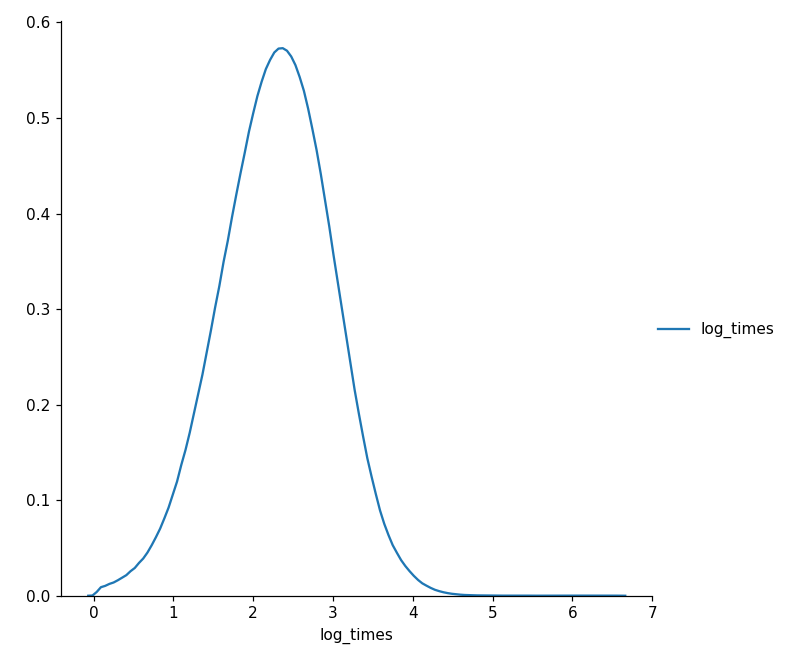

In [ ]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot, "log_times") \
      .add_legend()
plt.show()

<IPython.core.display.Javascript object>


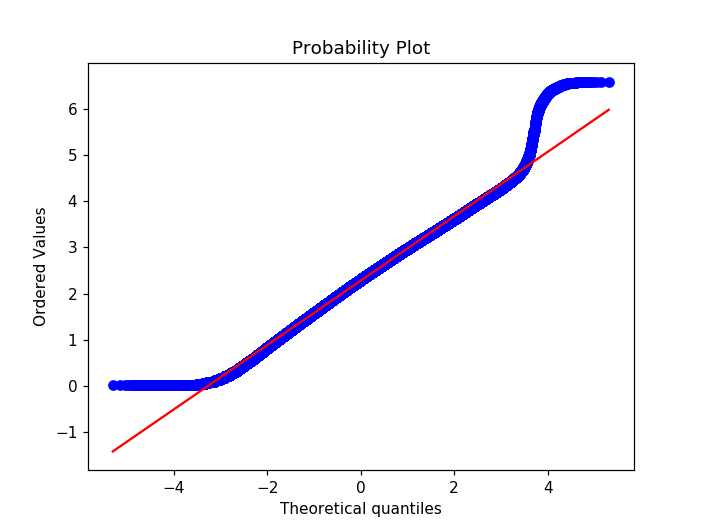

In [ ]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

### 4. Speed


<IPython.core.display.Javascript object>


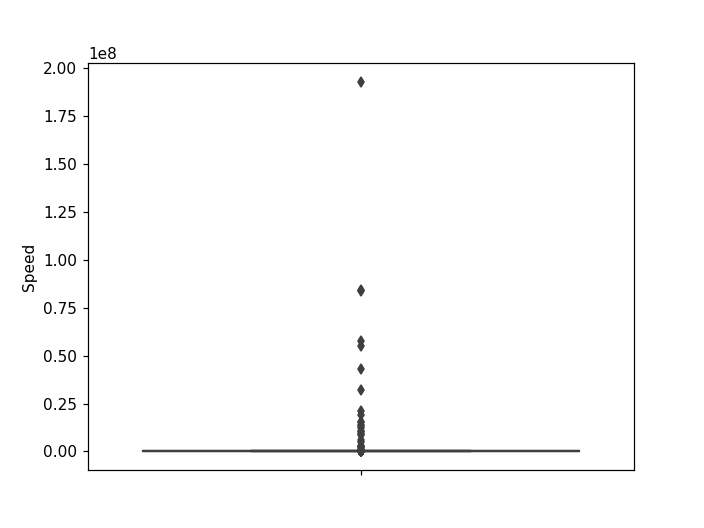

In [ ]:
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance'] / frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [ ]:
#calculating speed values at each percentile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0, 100, 10):
    var = frame_with_durations_modified["Speed"].values
    var = np.sort(var, axis = None)
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ", var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.85714284


In [ ]:
#calculating speed values at each percentile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90, 100):
    var = frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ", var[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.85714284


In [ ]:
#calculating speed values at each percentile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i, var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ", var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.85714284


In [ ]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [ ]:
#average speed of cabs
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.450173996027528

<b style='font-size:16px'>The avg speed speed is 12.45 miles/h, which is equal to 20 km/h.</b>


### 5. Trip Distance


<IPython.core.display.Javascript object>


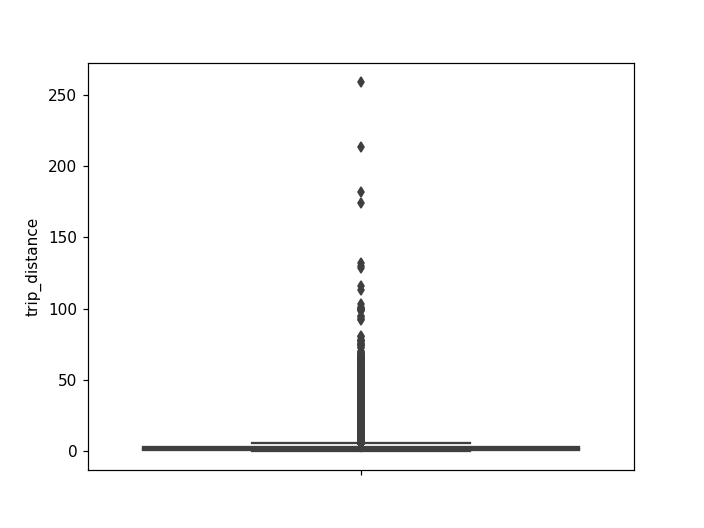

In [ ]:
# up to now we have removed the outliers based on trip durations and cab speeds
# checking if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

In [ ]:
#calculating trip distance values at each percentile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0, 100, 10):
    var = frame_with_durations_modified["trip_distance"].values
    var = np.sort(var, axis = None)
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ", var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is  258.9


In [ ]:
#calculating trip distance values at each percentile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90, 100):
    var = frame_with_durations_modified["trip_distance"].values
    var = np.sort(var, axis = None)
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ", var[-1])

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is  258.9


In [ ]:
#calculating trip distance values at each percentile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["trip_distance"].values
    var = np.sort(var, axis = None)
    print("{} percentile value is {}".format(99+i, var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ", var[-1])

99.0 percentile value is 18.17
99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100 percentile value is  258.9


In [ ]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified = frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

<IPython.core.display.Javascript object>


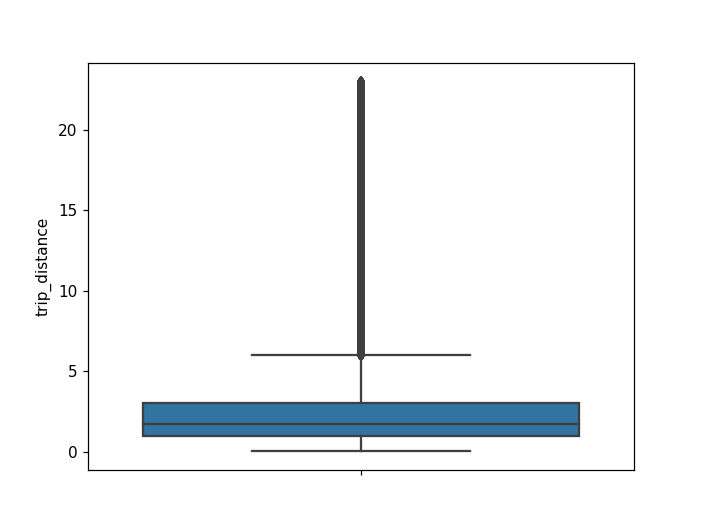

In [ ]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

### 6. Total Fare


<IPython.core.display.Javascript object>


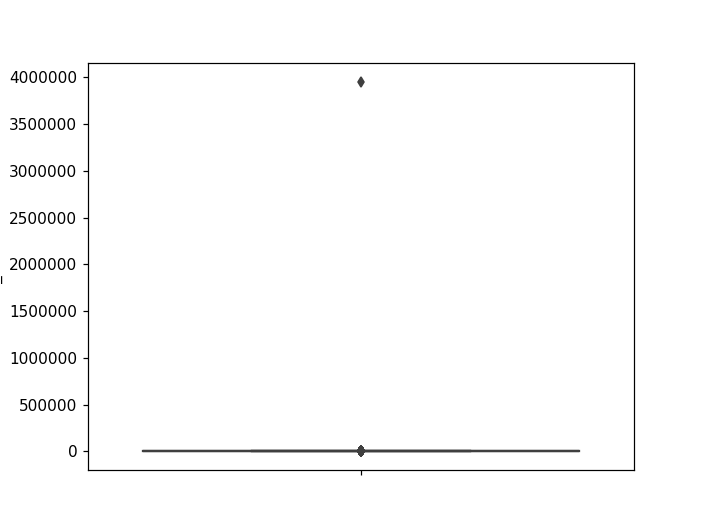

In [ ]:
# checking if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data = frame_with_durations_modified)
plt.show()

In [ ]:
#calculating total fare amount values at each percentile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0, 100, 10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var, axis = None)
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ", var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


In [ ]:
#calculating total fare amount values at each percentile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ", var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6


In [ ]:
#calculating total fare amount values at each percentile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var, axis = None)
    print("{} percentile value is {}".format(99+i, var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ", var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


<b>Observation:-</b> There is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis.


<IPython.core.display.Javascript object>


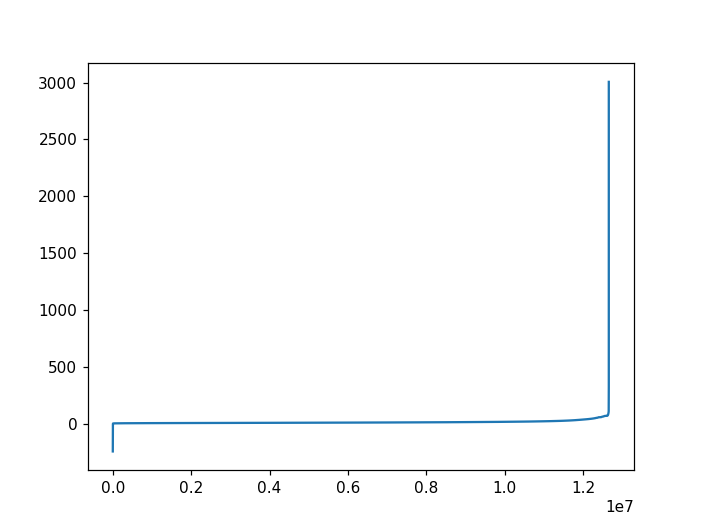

In [ ]:
# this plot shows us the sorted fare values
# found a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

<IPython.core.display.Javascript object>


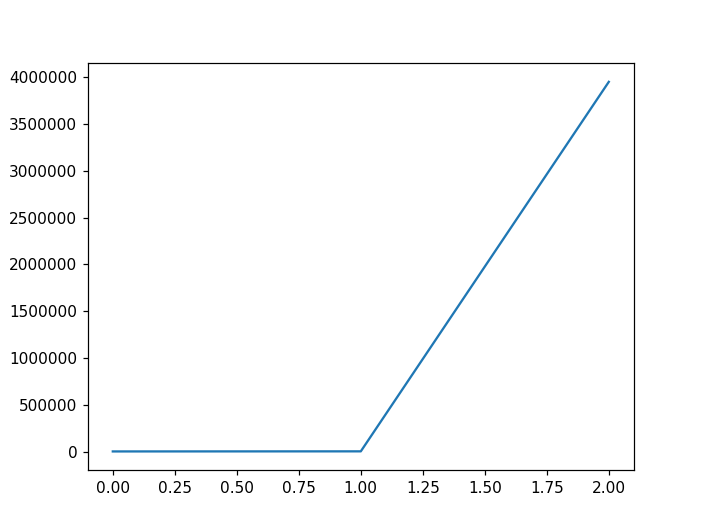

In [ ]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values
# we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

<IPython.core.display.Javascript object>


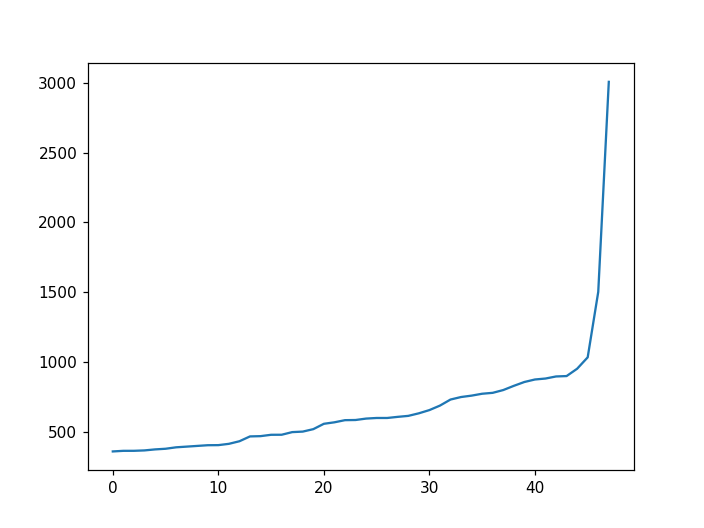

In [ ]:
# looking at values not including the last two points, we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

## Remove all outliers/erronous points


In [62]:
#
#removing all outliers based on our univariate analysis
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    print ("Number of pickup records = ", a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.70) &\
                       (new_frame.dropoff_latitude >= 40.58) & (new_frame.dropoff_latitude <= 40.92)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.58)& \
                       (new_frame.pickup_longitude <= -73.70) & (new_frame.pickup_latitude <= 40.92))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:", (a-b))

    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:", (a-c))
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:", (a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:", (a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:", (a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.70) &\
                       (new_frame.dropoff_latitude >= 40.58) & (new_frame.dropoff_latitude <= 40.92)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.58)& \
                       (new_frame.pickup_longitude <= -73.70) & (new_frame.pickup_latitude <= 40.92))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed", a - new_frame.shape[0])
    print ("---")
    return new_frame

In [ ]:
print ("Removing outliers in the month of January")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


# Data-preperation

## Clustering/Segmentation


In [ ]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j != i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist, distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ", cluster_len, "\nAvg. number of clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. number of clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)), "\nMin inter-cluster distance = ", min_dist, "\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters, so that there are more number of cluster regions that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.0945442325142543 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.7131298007387813 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter-cluster distance =  0.5185088176172206 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 32.0 
Min inter-cluster distance 

### Inference:

The main objective was to find a optimal min. distance (which roughly estimates to the radius of a cluster) between the clusters which we got as 40


### Plotting the cluster centers:


In [ ]:
# plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.73, -73.99], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

### Plotting the clusters:


<IPython.core.display.Javascript object>


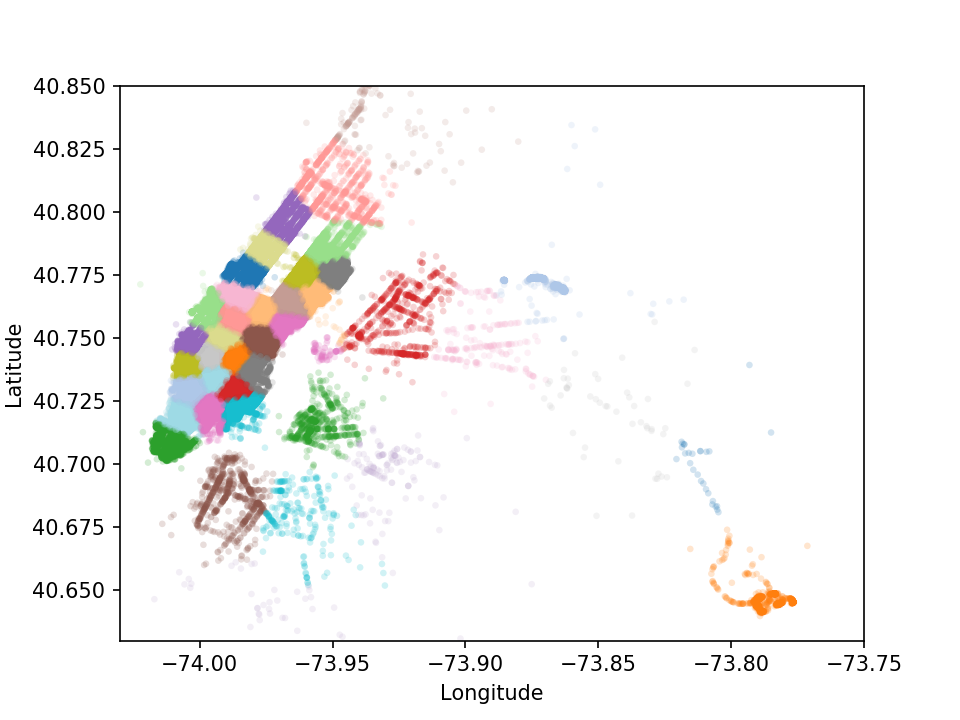

In [ ]:
# visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0, c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

## Time-binning


In [67]:
#
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix = unix_times[year-2015][month-1]
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [ ]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster', 'pickup_bins', 'trip_distance']].groupby(['pickup_cluster', 'pickup_bins']).count()

In [ ]:
# adding two more columns 'pickup_cluster' (to which cluster it belogns to) 
# and 'pickup_bins' (to which 10 mins intravel the trip belongs to)
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421329e+09,5.285319,34,2130
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420902e+09,9.983193,2,1419
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420902e+09,10.746269,16,1419
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420902e+09,16.071429,38,1419
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420902e+09,9.318378,22,1419


## Regression Models

### Train-Test Split
Before we start predictions using the tree based regression models, we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [ ]:
# Preparing data to be split into train and test

# we take number of pickups that are happened in last five 10 mins intervals
number_of_time_stamps = 5

# output varaible
output = []

tsne_lat = []

tsne_lon = []

# code each day 
# sun=0, mon=1, tue=2, wed=3, thu=4, fri=5, sat=6
tsne_weekday = []

# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4]
# fi=number of pickups happened in i+1th 10 mins intravel
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [ ]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 40*13099 == len(output)*len(output[0])

True

In [ ]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
alpha=0.3

predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
predict_list = []
tsne_flat_exp_avg = []
fr_am_final = pd.DataFrame(columns= ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
for r in range(0,40):
    YJan = np.fft.fft(np.array(regions_cum[r][0:4464]))
    freqJan = np.fft.fftfreq((4464), 1)

    
    YFeb = np.fft.fft(np.array(regions_cum[r])[4464:(4176+4464)])
    freqFeb = np.fft.fftfreq((4176), 1)

    
    YMar = np.fft.fft(np.array(regions_cum[r])[(4176+4464):(4176+4464+4464)])
    freqMar = np.fft.fftfreq((4464), 1)

    fr_am_jan = pd.DataFrame()
    fr_am_feb = pd.DataFrame()
    fr_am_mar = pd.DataFrame()
    
    fr_am_jan['Frequency'] = freqJan
    fr_am_jan['Amplitude'] = YJan
    fr_am_feb['Frequency'] = freqFeb
    fr_am_feb['Amplitude'] = YFeb
    fr_am_mar['Frequency'] = freqMar
    fr_am_mar['Amplitude'] = YMar
    
    fr_am_list_jan = []
    fr_am_list_feb = []
    fr_am_list_mar = []
    
    fr_am_jan_sorted = fr_am_jan.sort_values(by=["Amplitude"], ascending=False)[:5].reset_index(drop=True).T
    fr_am_feb_sorted = fr_am_feb.sort_values(by=["Amplitude"], ascending=False)[:5].reset_index(drop=True).T
    fr_am_mar_sorted = fr_am_mar.sort_values(by=["Amplitude"], ascending=False)[:5].reset_index(drop=True).T
    
    for i in range(0,5):
        fr_am_list_jan.append(float(fr_am_jan_sorted[i]['Frequency']))
        fr_am_list_jan.append(float(fr_am_jan_sorted[i]['Amplitude']))

        fr_am_list_feb.append(float(fr_am_feb_sorted[i]['Frequency']))
        fr_am_list_feb.append(float(fr_am_feb_sorted[i]['Amplitude']))

        fr_am_list_mar.append(float(fr_am_mar_sorted[i]['Frequency']))
        fr_am_list_mar.append(float(fr_am_mar_sorted[i]['Amplitude']))

    fr_am_new_jan = pd.DataFrame([fr_am_list_jan]*4464)
    fr_am_new_feb = pd.DataFrame([fr_am_list_feb]*4176)
    fr_am_new_mar = pd.DataFrame([fr_am_list_mar]*4464)

    fr_am_new_jan.columns = ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5',]
    fr_am_new_feb.columns = ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5',]
    fr_am_new_mar.columns = ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5',]
    
    
    fr_am_final = fr_am_final.append(fr_am_new_jan, ignore_index=True)
    fr_am_final = fr_am_final.append(fr_am_new_feb, ignore_index=True)
    fr_am_final = fr_am_final.append(fr_am_new_mar, ignore_index=True)
    
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [ ]:
fr_am_final.head(5)

,f_1,a_1,f_2,a_2,f_3,a_3,f_4,a_4,f_5,a_5
0,0.0,369774.0,-0.012993,24998.122651,0.012993,24998.122651,0.000448,15434.851794,-0.000448,15434.851794
1,0.0,369774.0,-0.012993,24998.122651,0.012993,24998.122651,0.000448,15434.851794,-0.000448,15434.851794
2,0.0,369774.0,-0.012993,24998.122651,0.012993,24998.122651,0.000448,15434.851794,-0.000448,15434.851794
3,0.0,369774.0,-0.012993,24998.122651,0.012993,24998.122651,0.000448,15434.851794,-0.000448,15434.851794
4,0.0,369774.0,-0.012993,24998.122651,0.012993,24998.122651,0.000448,15434.851794,-0.000448,15434.851794


In [ ]:
fr_am_final.drop(['f_1'],axis=1,inplace=True)

fr_am_final = fr_am_final
fr_am_final = fr_am_final.fillna(0)

In [ ]:
fr_am_final.head(5)

,a_1,f_2,a_2,f_3,a_3,f_4,a_4,f_5,a_5
0,369774.0,-0.012993,24998.122651,0.012993,24998.122651,0.000448,15434.851794,-0.000448,15434.851794
1,369774.0,-0.012993,24998.122651,0.012993,24998.122651,0.000448,15434.851794,-0.000448,15434.851794
2,369774.0,-0.012993,24998.122651,0.012993,24998.122651,0.000448,15434.851794,-0.000448,15434.851794
3,369774.0,-0.012993,24998.122651,0.012993,24998.122651,0.000448,15434.851794,-0.000448,15434.851794
4,369774.0,-0.012993,24998.122651,0.012993,24998.122651,0.000448,15434.851794,-0.000448,15434.851794


In [ ]:
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [ ]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]
fr_am_final_train = pd.DataFrame(columns=['a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
fr_am_final_test = pd.DataFrame(columns=['a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
for i in range(0,40):
    fr_am_final_train = fr_am_final_train.append(fr_am_final[i*13099:(13099*i+9169)] )
fr_am_final_train.reset_index(inplace=True)
for i in range(0,40):
    fr_am_final_test = fr_am_final_test.append(fr_am_final[(13099*(i))+9169:13099*(i+1)])
fr_am_final_test.reset_index(inplace=True)

In [ ]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 40 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 40 Number of data points in test data 3930 Each data point contains 5 features


In [ ]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [ ]:
# converting lists of lists into sinle list i.e flatten

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [ ]:
# preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(366760, 9)


In [ ]:
# preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(157200, 9)


In [ ]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,118,106,104,93,102,40.776228,-73.982119,4,100
1,106,104,93,102,101,40.776228,-73.982119,4,100
2,104,93,102,101,120,40.776228,-73.982119,4,114
3,93,102,101,120,131,40.776228,-73.982119,4,125
4,102,101,120,131,164,40.776228,-73.982119,4,152


In [ ]:
df_test_lm = pd.concat([df_test, fr_am_final_test], axis=1)
df_train_lm = pd.concat([df_train, fr_am_final_train], axis=1)

df_test_lm.head()
print(df_test.shape)
print(fr_am_final_test.shape)

(157200, 9)
(157200, 10)


In [ ]:
df_test_lm.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,index,a_1,f_2,a_2,f_3,a_3,f_4,a_4,f_5,a_5
0,118,106,104,93,102,40.776228,-73.982119,4,100,9169,391598.0,-0.012769,10930.478599,0.012769,10930.478599,-0.020833,10662.395979,0.020833,10662.395979
1,106,104,93,102,101,40.776228,-73.982119,4,100,9170,391598.0,-0.012769,10930.478599,0.012769,10930.478599,-0.020833,10662.395979,0.020833,10662.395979
2,104,93,102,101,120,40.776228,-73.982119,4,114,9171,391598.0,-0.012769,10930.478599,0.012769,10930.478599,-0.020833,10662.395979,0.020833,10662.395979
3,93,102,101,120,131,40.776228,-73.982119,4,125,9172,391598.0,-0.012769,10930.478599,0.012769,10930.478599,-0.020833,10662.395979,0.020833,10662.395979
4,102,101,120,131,164,40.776228,-73.982119,4,152,9173,391598.0,-0.012769,10930.478599,0.012769,10930.478599,-0.020833,10662.395979,0.020833,10662.395979


### Using Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve, GridSearchCV

lr_reg=LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr_reg,parameters, cv=None)
grid.fit(df_train, tsne_train_output)

print(grid.best_estimator_)
print(grid.best_params_)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
{'copy_X': True, 'fit_intercept': True, 'normalize': True}


In [ ]:
lr_reg=LinearRegression(copy_X=True, fit_intercept=True, normalize=True).fit(df_train, tsne_train_output)
y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

## Comparison between Baseline Models

We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good our model is with predictions. <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs.


In [ ]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ", mean_err[0],"      MSE: ", median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ", mean_err[1],"       MSE: ", median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ", mean_err[2],"      MSE: ", median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ", mean_err[3],"      MSE: ", median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ", mean_err[4],"      MSE: ", median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ", mean_err[5],"      MSE: ", median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.1821155173392136       MSE:  400.0625504032258
Moving Averages (2016 Values) -                        MAPE:  0.14292849686975506        MSE:  174.84901993727598
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.1784869254376018       MSE:  384.01578741039424
Weighted Moving Averages (2016 Values) -               MAPE:  0.13551088436182082       MSE:  162.46707549283155
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.17783550194861494       MSE:  378.34610215053766
Exponential Moving Averages (2016 Values) -         MAPE:  0.135091526

<IPython.core.display.Javascript object>


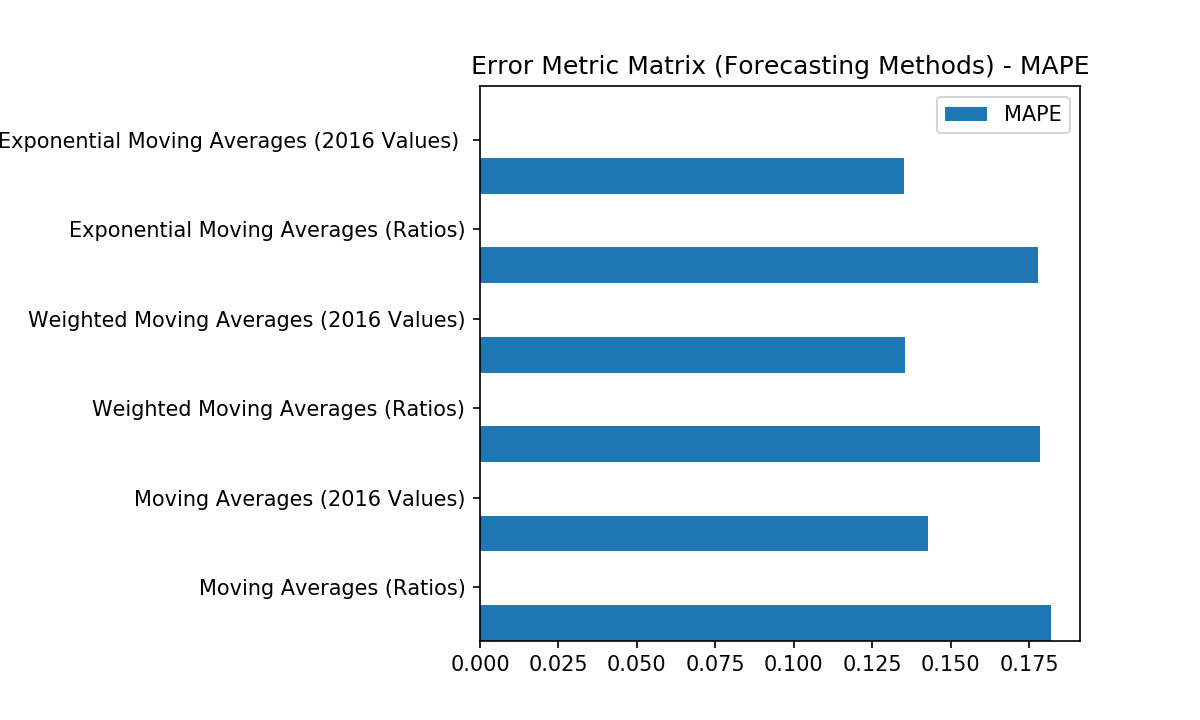

<IPython.core.display.Javascript object>


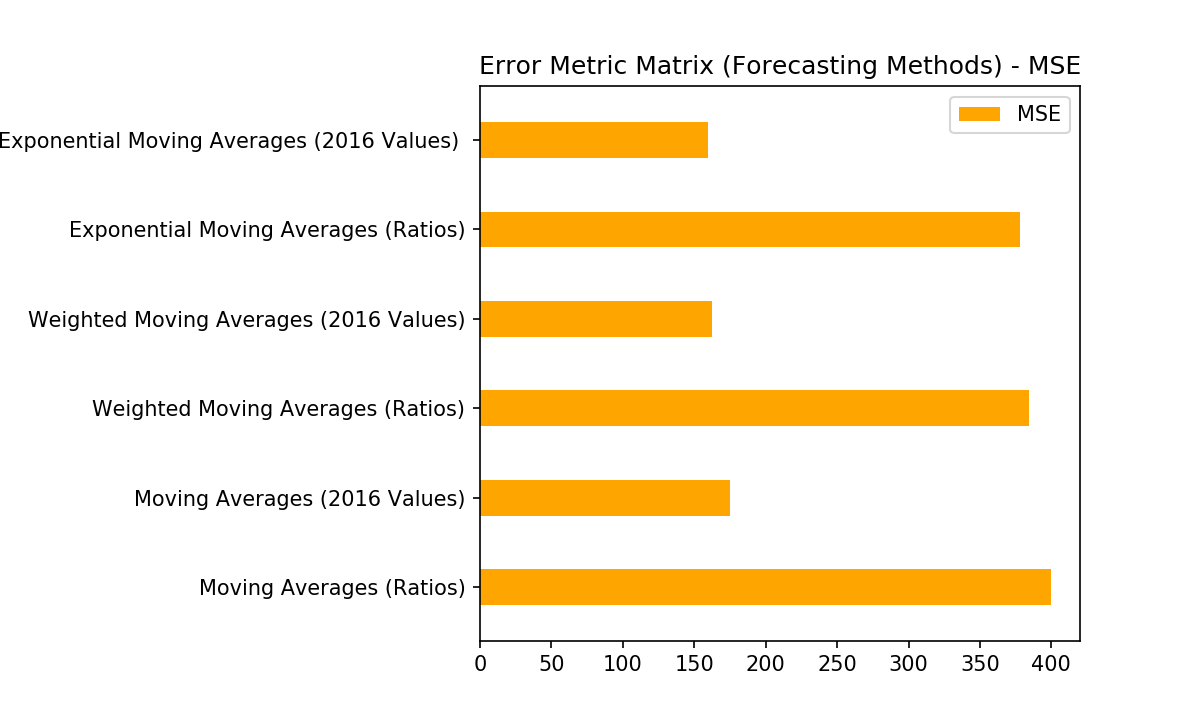

In [ ]:
df = pd.DataFrame(dict(graph=['Moving Averages (Ratios)', 'Moving Averages (2016 Values)', 'Weighted Moving Averages (Ratios)','Weighted Moving Averages (2016 Values)',
                                'Exponential Moving Averages (Ratios)', 'Exponential Moving Averages (2016 Values) '], n=mean_err, m=median_err)) 

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df.n, width, label='MAPE')

fig.set_figwidth(8)
plt.gcf().subplots_adjust(left = 0.40)
plt.title("Error Metric Matrix (Forecasting Methods) - MAPE")
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()

plt.show()

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind + width, df.m, width, color="orange", label='MSE')
fig.set_figwidth(8)
plt.gcf().subplots_adjust(left = 0.40)
plt.title("Error Metric Matrix (Forecasting Methods) - MSE")
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()

plt.show()

## Result


In [ ]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Error Metric Matrix (Tree Based Regression Methods) -  MAPE "
ptable.field_names = ["Model",'MAPE_train','MAPE__test']
ptable.add_row(["Baseline Model -   ", train_mape[0], test_mape[0]])
ptable.add_row(["Exponential Averages Forecasting -  ", train_mape[1], test_mape[1]])
ptable.add_row(["Linear Regression -  ", train_mape[4], test_mape[4]])
ptable.add_row(["Linear Regression with Fourier Transforms -  ", train_mape[5], test_mape[5]])
ptable.add_row(["Random Forest Regression -  ", train_mape[2], test_mape[2]])
ptable.add_row(["XgBoost Regression - ", train_mape[3], test_mape[3]])
ptable.add_row(["\n","\n","\n"])

print(ptable)
with open('NYC_Result.txt', 'w') as w:
    w.write(str(ptable))

+-----------------------------------------------+---------------------+---------------------+
|                     Model                     |      MAPE_train     |      MAPE__test     |
+-----------------------------------------------+---------------------+---------------------+
|              Baseline Model -                 | 0.14005275878666593 | 0.13653125704827038 |
|      Exponential Averages Forecasting -       | 0.13289968436017227 | 0.12936180420430524 |
|             Linear Regression -               | 0.13331572016045437 |  0.1291202994009687 |
| Linear Regression with Fourier Transforms -   |  0.1332437711181196 | 0.12889809969073623 |
|          Random Forest Regression -           | 0.11211457303899049 |  0.1265956328438887 |
|             XgBoost Regression -              | 0.12966255411204525 | 0.12717363879979662 |
|                                               |                     |                     |
|                                               |           

<IPython.core.display.Javascript object>


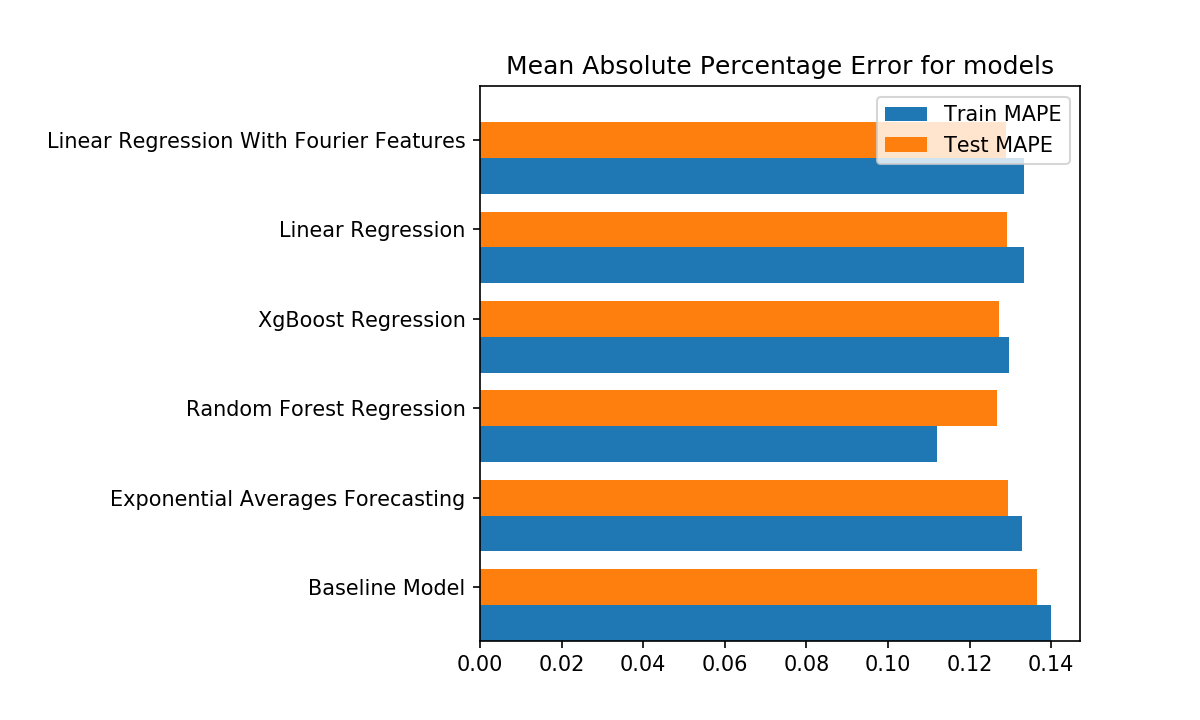

In [ ]:
df = pd.DataFrame(dict(graph=['Baseline Model', 'Exponential Averages Forecasting', 'Random Forest Regression','XgBoost Regression','Linear Regression','Linear Regression With Fourier Features'], n=train_mape, m=test_mape)) 

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df.n, width, label='Train MAPE')
ax.barh(ind + width, df.m, width, label='Test MAPE')
fig.set_figwidth(8)
plt.gcf().subplots_adjust(left = 0.40)
plt.title("Mean Absolute Percentage Error for models")
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()

plt.show()